In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import time
import pickle
import os

from setup.univ_setup import *
from setup.utils import *
from factor_mining.combine_factors import *
from factor_mining.factor_preprocessing import *
from performance_analysis.pa_core import *

from backtest.BackTestSinglePeriod import *
from backtest.BackTest import *
from backtest.factor_mimicing_pfl import *

from factor_mining.attribution.factor_correlation import *

from factor_mining.Mark0 import * # This is alpha file

In [ ]:
### universe setup ###
print('Setup R3000 universe')
datadir = '/home/derek-qi/Documents/R3000_Data/data/r3000/'
start = time()
if os.path.exists(datadir + 'univ.pkl'):
    print('use existing binary file')
    with open(datadir + 'univ.pkl', 'rb') as univ_fh:
        univ = pickle.load(univ_fh)
    
else:
    print('construct from csv')
    big_table_dir = datadir + 'big_table_full_v4.csv'
    univ = univ_setup(big_table_dir)
    # filt_by_name(univ) # This is slow！
    with open(datadir + 'univ.pkl','wb') as fh:
        pickle.dump(univ, fh)
end = time()
print('%f seconds' % (end - start))

all_counts = get_count(univ)

filt_na(univ)
all_no_na = get_count(univ)
import warnings
warnings.filterwarnings("ignore")

### model configuration ###
print('Calculate factors')
# define and calculate all factors
factors = alpha_four_factors(univ)

# concat into factor exposure matrices
factor_exp_mat = combine_factors(factors)
filt_na(factor_exp_mat)

# Preprocessing factor expsure matrices
print('Scale each factor')
factor_exp_mat = process_batch(factor_exp_mat, standardize)
print('Winsorize with +/- 3 std')
factor_exp_mat = process_batch(factor_exp_mat, winsorize_std)
print('Done')

has_mmt = get_count(factor_exp_mat)
### Filt the universe ###
print('Filt the untradables')

filt_byval(univ, 'in_r3000', 0)
filt_byval(univ, 'price', 10)
# filt_byval(univ, 'not_in_MA', 0)
filt_byval(univ, 'volume', 1500000)
print('Done')
tradable = get_count(univ)

In [7]:
factor_exp_mat = merge(factor_exp_mat, univ, right_cols=['f_log_ret_1', 'industry'])
itsc = get_count(factor_exp_mat)

In [11]:
np.max(abs(tradable.loc[27:,'count'] - itsc.loc[27:,'count']))

58

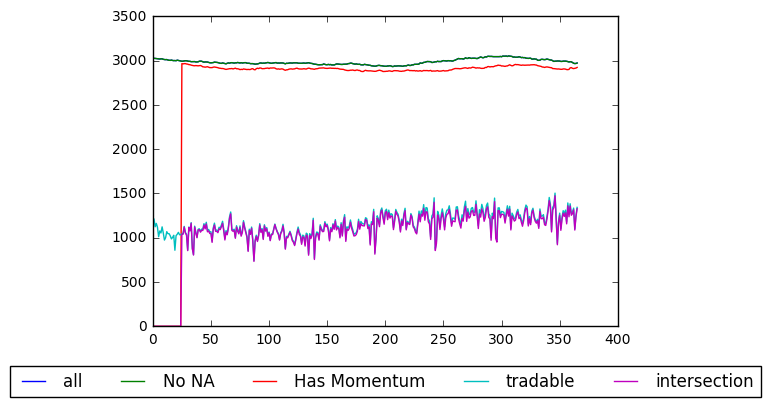

In [8]:
plt.plot(all_counts['count'], label='all')
plt.plot(all_no_na['count'], label='No NA')
plt.plot(has_mmt['count'], label='Has Momentum')
plt.plot(tradable['count'], label='tradable')
plt.plot(itsc['count'], label='intersection')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=5)
plt.show()

In [ ]:
from pdb import set_trace as bp
class BackTest(object):
	def __init__(self, univ:dict, factor_exp_mat:dict, daterange:list, sp_calc:BackTestSinglePeriod, rebal=1):
		self.univ = univ
		self.factor_exp_mat = factor_exp_mat
		self.dstart, self.dend = np.min(daterange), np.max(daterange)
		self.rebal = rebal
		self.sp_calc = sp_calc
		self.has_pnl, self.has_pa = False, False

	def get_config(self):
		config = {}
		config['Strategy Name'] = self.sp_calc.get_func_name()
		config['Strategy config'] = self.sp_calc.get_config()
		config['Date range'] = [self.dstart.strftime('%Y-%m-%d'), self.dend.strftime('%Y-%m-%d')]
		config['Rebalance period'] = self.rebal

		if self.has_pnl:
			pass
		
		if self.has_pa:
			pass

		return config

	def calc_pnl(self, **kwargs):
		datelst = sorted(self.univ.keys())
		tin_lst, ptfl_lst, pnl_lst = [], [], []
		count = 0
		for t in datelst:
			if t < self.dstart or t > self.dend:
				continue

			if count == 0:
# 				bp()              
				ptfl_sp, pnl_sp = self.sp_calc.calc_pnl(self.univ, self.factor_exp_mat, t, **kwargs)
			else:
				ret_name = 'f_log_ret_1'
				op_na = pd.merge(ptfl_sp, self.univ[t], on='ticker', how='inner') # This stands for old portfolio, new analytics
				pnl_sp = np.dot(op_na['weight'], op_na[ret_name])

			tin_lst.append(t)
			ptfl_lst.append(ptfl_sp.copy())
			pnl_lst.append(pnl_sp)

			count -= 1
			count %= self.rebal

		self.pnl_lst = pd.DataFrame({'date':tin_lst, 'pnl':pnl_lst})
		self.ptfl_lst = ptfl_lst
		self.has_pnl = True
		return ptfl_lst, pnl_lst

	def simple_pa(self, **kwargs):
		self.pa = simple_pa(self.pnl_lst)
		self.has_pa = True


class FactorMimicPtflSpcalc(BackTestSinglePeriod):
	def __init__(self, factor_name, weighting=None):
		self.factor_name = factor_name
		self.weighting = weighting

	def get_config(self):
		config = {}
		config['Signal variable'] = self.signal
		config['Selection range'] = self.sel_range
		config['Weighting'] = self.weighting
		return config

	def get_func_name(self):
		return 'Factor Mimicing Portfolio'

	def calc_pnl(self, univ, factor_exp_mat, t, **kwargs):
		'''
		Create a factor mimicing portfolio
		'''
		ret_name = 'f_log_ret_1'
		univ_sp, factor_exp_sp = univ[t].copy(), factor_exp_mat[t].copy()

		merged = pd.merge(univ_sp[['date', 'ticker', ret_name]], factor_exp_sp[['ticker', self.factor_name]], how='inner', on='ticker')
		if self.weighting:
			w = np.diag(1 / merged[self.weighting])
		else:
			w = np.eye(merged.shape[0])
# 		bp()
		beta = np.asarray(merged[self.factor_name])
		beta = beta.reshape(len(beta), 1)
		h = (np.linalg.inv((beta.T).dot(w.dot(beta))).dot((beta.T).dot(w))).T
		fmpfl = merged[['date', 'ticker', ret_name]]
		fmpfl['weight'] = h
		pnl_sp = np.dot(fmpfl['weight'], fmpfl[ret_name])
		ptfl_sp = fmpfl[['date', 'ticker', 'weight']]
		return ptfl_sp, pnl_sp

In [ ]:
spcalc = FactorMimicPtflSpcalc(factor_name='vol10', weighting='vol10')
bt = BackTest(univ=univ, factor_exp_mat=factor_exp_mat, daterange=[datetime(2014, 1, 1), datetime(2016, 12, 31)], sp_calc=spcalc, rebal=1)
ptfl_lst, pnl_lst = bt.calc_pnl()    

In [ ]:
for fname in ['beta', 'vol10', 'log_market_cap', 'momentum']:
    spcalc = FactorMimicPtflSpcalc(factor_name=fname)
    bt = BackTest(univ=univ, factor_exp_mat=factor_exp_mat, daterange=[datetime(2014, 1, 1), datetime(2016, 12, 31)], sp_calc=spcalc, rebal=1)
    ptfl_lst, pnl_lst = bt.calc_pnl()
    plt.plot(np.cumsum(pnl_lst), label=fname)
plt.legend(loc=0)
plt.show()

In [ ]:
pnl_lst

In [ ]:
np.sum(abs(ptfl_lst[-1]['weight']))